## Введение. Постановка целей и задач.

Цель: Создать и обучить две модели, ARIMA и Prophet. Выявить наилучшую модель для предсказания солнечной активности. Солнечная активность влияет на все аспекты человеческой деятельности, в частности на работу полупроводникой техники, поэтому очень важно иметь надёжную и быструю модель предсказания.

Задачи:

1.   Создать и обучить модели ARIMA и Prophet;
2.   Создать прогноз обоих моделей;
3.   Сравнить прогноз и предсказание;
4.   Рассчитать качество полученных моделей и прогноза.





In [ ]:
!pip install alive_progress -q
!pip install pmdarima -q
!pip install prophet -q

import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.statespace.sarimax import SARIMAX
from alive_progress import alive_bar
from pmdarima import auto_arima
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
df = sm.datasets.sunspots.load_pandas().data

### Знакомство с данными.

Смотрим шапку датасета.

In [ ]:
df.head()

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   YEAR         309 non-null    float64
 1   SUNACTIVITY  309 non-null    float64
dtypes: float64(2)
memory usage: 5.0 KB


In [ ]:
ref_range = pd.date_range('1700', periods=309, freq='Y')
df.index.difference(ref_range)

RangeIndex(start=0, stop=309, step=1)

Имеем 309 записей среднегодовой солнечной активности, два столбца YEAR и SUNACTIVITY, оба имеют тип float64. Пропусков нет.

## Предобработка данных

Преобразовываем столбец YEAR в DateTime, делаем его индексом датасета.

In [ ]:
df.YEAR = pd.to_datetime(df.YEAR, format='%Y')
df.set_index('YEAR', inplace=True)
df.head()

,SUNACTIVITY
YEAR,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0


## EDA или разведочный анализ данных.

Посмотрим на график временного ряда.

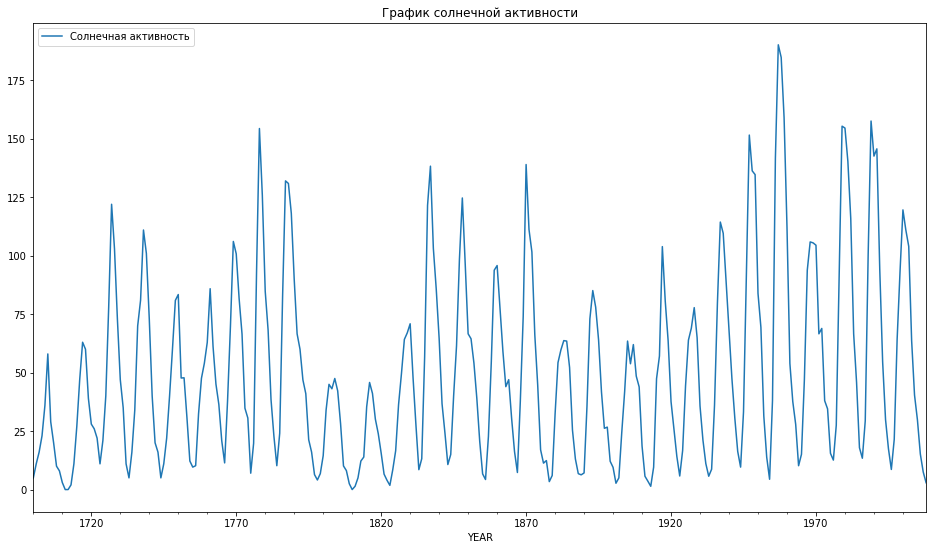

In [ ]:
ax = df.plot(figsize=(16,9), title='График солнечной активности').legend(['Солнечная активность'])

Также проведём декомпозицию временного ряда.

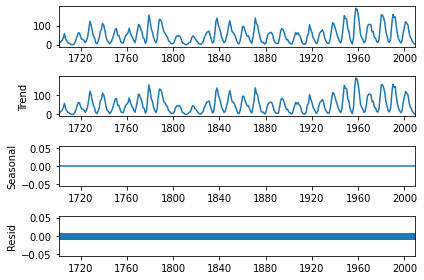

In [ ]:
fig = seasonal_decompose(df).plot()

Кажется, что сезонности и тренда нет, но согласно исследованиям:

"Солнечными циклами называются периодические изменения в солнечной активности. Предполагается наличие большого количества циклов с периодами 11, 22, 87, 210, 2300 и 6000 лет. Основные циклы продолжительностью 11, 22 и 2300 лет носят также название, соответственно, циклов Швабе, Хейла и Холлстатта."

Посмотрим на сезонности доступные в нашем датасете.

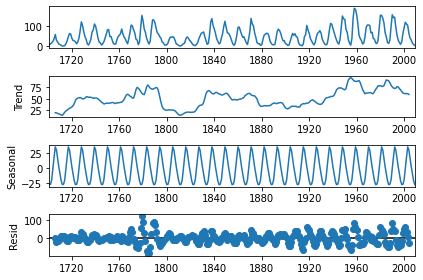

In [ ]:
fig = seasonal_decompose(df, period=11).plot()

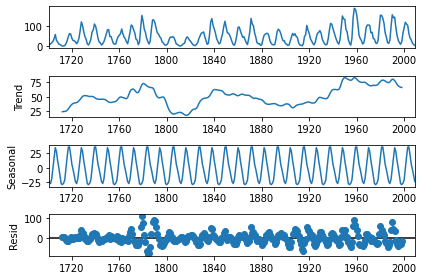

In [ ]:
fig = seasonal_decompose(df, period=22).plot()

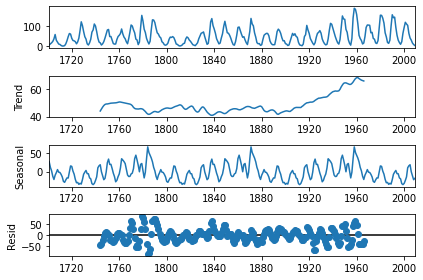

In [ ]:
fig = seasonal_decompose(df, period=87).plot()

После 87 лет начинает явно прослеживаться тренд.

## Построение моделей, анализ результатов.

**Модель SARIMAX**

Построим модель ARIMA. Для этого получим её гиперпараметры ARIMA(p, d, q) с помощью auto_arima.

In [ ]:
auto_arima(df).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  309
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1280.477
Date:                Sun, 05 Feb 2023   AIC                           2572.954
Time:                        19:46:04   BIC                           2595.335
Sample:                    12-31-1700   HQIC                          2581.903
                         - 12-31-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6145      0.026     62.096      0.000       1.564       1.665
ar.L2         -0.9354      0.022    -41.820      0.000      -0.979      -0.892
ma.L1         -1.4392      0.059    -24.590      0.000      -1.554      -1.324
ma.L2          0.4545      0.095      4.783      0.000       0.268       0.641
ma.L3          0.1285      0.060      2.143      0.032       0.011       0.246
sigma2       236.7573     16.333     14.495      0.000     204.744     268.770
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                43.72
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.54
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Разделим данные на тренировочную и тестовую выборку.

In [ ]:
train = df[:-15]
test = df[-15:]

Подберём оптимальный гиперпараметр AR(p) с помощью скрипта, сранивая MAPE предсказания.

In [ ]:
with alive_bar(50, force_tty=True) as bar:
  for i in range(1, 51):
    bar()
    model = SARIMAX(train, order=(i, 1, 3)).fit()
    prediction = model.forecast(15)
    mape = MAPE(test, prediction)
    if mape < 1.5:
      print(i, mape)

on 19: 19 1.4006303562042572
on 24: 24 1.2288152894414979
on 25: 25 1.315765007434232
on 31: 31 1.2663545793773001
on 32: 32 1.2429735593554037
on 33: 33 1.1857078536645043
on 34: 34 1.0663870070488886
on 35: 35 1.1518632804982507
on 36: 36 1.2769006105769207
on 37: 37 1.352653946941828
|████████████████████████████████████████| 50/50 [100%] in 16:07.4 (0.05/s)                                             


Найдено 10 результатов с минимальной ошибкой. Но для нашей модели подходит только p=19, так как количество солнечных пятен не может быть меньше 0. Обучим модель на тренировочных данных с полученными гиперпараметрами.

In [ ]:
st_prediction = SARIMAX(train, order=(19, 1, 3)) \
  .fit().forecast(15)

Визуально посмотрим на таблицу с реальными данными и предсказанием.

In [ ]:
test.join(st_prediction)

,SUNACTIVITY,predicted_mean
YEAR,,
1994-01-01,29.9,21.623439
1995-01-01,17.5,17.898068
1996-01-01,8.6,17.928933
1997-01-01,21.5,33.743829
1998-01-01,64.3,70.730290
1999-01-01,93.3,97.586637
2000-01-01,119.6,118.193529
2001-01-01,111.0,113.622501
2002-01-01,104.0,90.743809


Две последних строки сильно отличаются.

In [ ]:
mse = MSE(test, st_prediction)
print('ARIMA')
print('MAPE:', MAPE(test, st_prediction))
print('RMSE:', mse**.5)
print('MSE:', mse)

ARIMA
MAPE: 1.4006303562042572
RMSE: 14.26209833381726
MSE: 203.40744888347308


Процент ошибки довольно низок, по MAPE он составляет 1.4%.

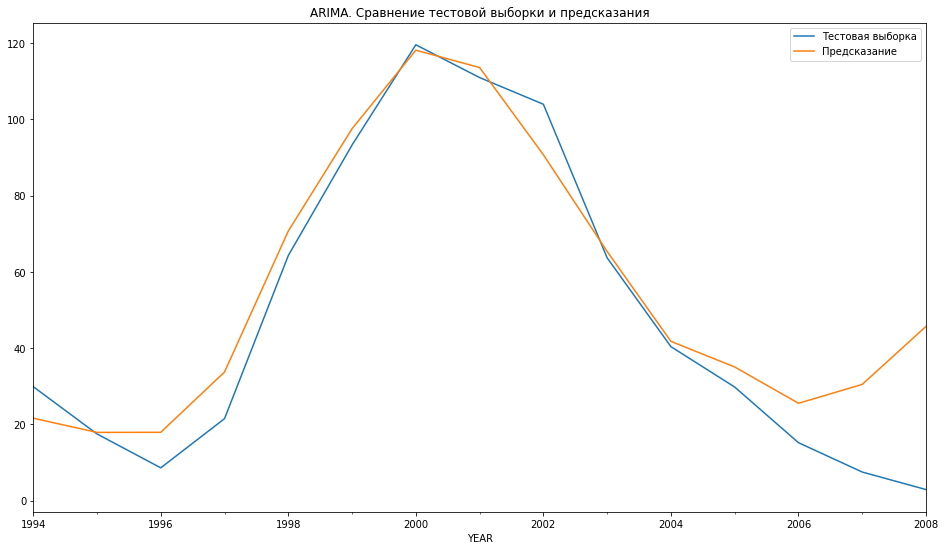

In [ ]:
ax1 = test.plot(title='ARIMA. Сравнение тестовой выборки и предсказания')
ax2 = st_prediction.plot(figsize=(16,9), legend=True) \
  .legend(['Тестовая выборка', 'Предсказание'])

Теперь переобучим нашу модель на всех данных.


In [ ]:
s_prediction = SARIMAX(df, order=(19, 1, 3)).fit().predict(start=0, end=len(df)+14)
s_prediction[-15:]

2009-01-01    25.378236
2010-01-01    58.395526
2011-01-01    85.173867
2012-01-01    93.103712
2013-01-01    83.295307
2014-01-01    69.435343
2015-01-01    48.091926
2016-01-01    28.546401
2017-01-01    10.253674
2018-01-01     3.480399
2019-01-01    13.741454
2020-01-01    34.745460
2021-01-01    65.296212
2022-01-01    84.338276
2023-01-01    90.976004
Freq: AS-JAN, Name: predicted_mean, dtype: float64

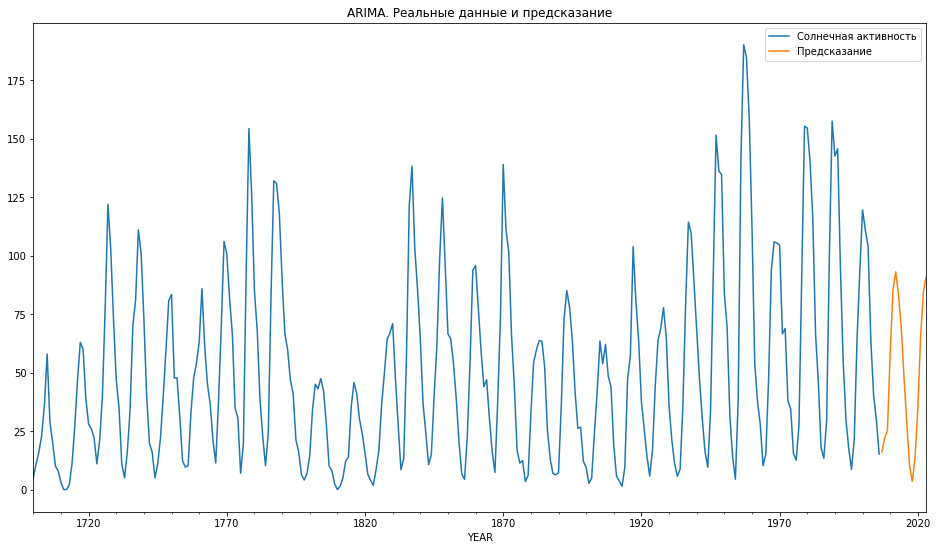

In [ ]:
ax1 = df[:-2].plot(title='ARIMA. Реальные данные и предсказание')
ax2 = s_prediction[-17:].plot(figsize=(16,9)) \
  .legend(['Солнечная активность', 'Предсказание'])

Временные метки чуть сдвинуты, для лучшего восприятия графика. Стоит упомянуть, что не смотря на отсутствие сезонности в рекомендации гиперпараметров auto_arima, процент ошибки довольно низок.

**Модель Prophet**

Теперь построим модель Prophit. Для этой модели нужна специфическая настройка датасета. Столбец с датой должен называться 'ds', а столбец с данными 'y'.

In [ ]:
df_prophet = df.reset_index().copy()
df_prophet.columns = ['ds', 'y']
df_prophet.head()

,ds,y
0,1700-01-01,5.0
1,1701-01-01,11.0
2,1702-01-01,16.0
3,1703-01-01,23.0
4,1704-01-01,36.0


Снова разделим данные на тренировочную и тестовую выборку. Следует учитывать специфику Prophet, он плохо взаимодействует с очень большими временными рядами, на несколько сотен лет, поэтому отрежем 30 лет от начала датасета, во избежание ошибок библиотеки. Количество лет установленно экспериментально.

In [ ]:
train_prophet = df_prophet[30:-15]
test_prophet = df_prophet[-15:]

Без сезонности Prophet не оправдал возложенных на него надежд, прогноз и тестовые данные сильно различаются. Поэтому определяем настройки сезонности, так как встроенных настроек вековой сезонности Prophet не имеет.

In [ ]:
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

with alive_bar(100, force_tty=True) as bar:
  for i in range(1, 101):
    for j in range(87, 150):
      bar()
      model = Prophet()
      model.add_seasonality(
        name = 'century',
        fourier_order = i,
        period = j
      )
      model.fit(train_prophet)
      future = model.make_future_dataframe(periods=15, freq='YS')
      forecast = model.predict(future)
      mape = MAPE(test_prophet['y'], forecast['yhat'][-15:])
      if mape < 1.5:
        print(i, j, mape)

on 13: 13 103 1.1740287326818266
on 14: 14 103 1.1942191835351854
on 15: 15 103 1.1618776156411166
on 16: 16 103 1.1947851317824083
on 17: 17 103 1.2108564406067448
on 18: 18 103 1.0607550621555
on 19: 19 103 1.0882496317183803
on 20: 20 103 1.0176545810532043
on 21: 21 103 0.9491388530775696
|████████████████████████████████████████| 100/100 [100%] in 38.4s (2.62/s)                                             


Оптимальными гиперпараметрами стали period = 103 и fourier_order = 21.

Посмотрим декомпозицию ряда с периодом 103.

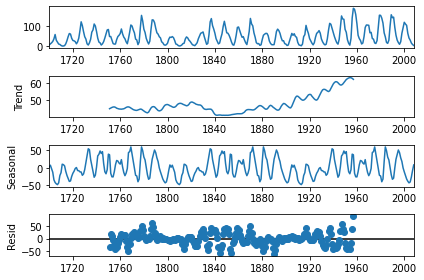

In [ ]:
fig = seasonal_decompose(df, period=103).plot()

Действительно хорошо заметен тренд. Применим эти гиперпараметры к модели.

In [ ]:
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

model = Prophet()
model.add_seasonality(
    name = 'century',
    fourier_order = 21,
    period = 103
)
model.fit(train_prophet)
future = model.make_future_dataframe(periods=15, freq='YS')
forecast = model.predict(future)

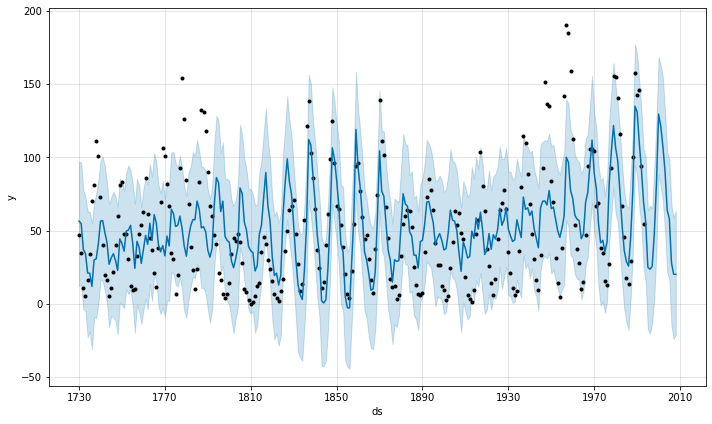

In [ ]:
ax = model.plot(forecast)

In [ ]:
p_prediction = test_prophet.set_index('ds').join(forecast.set_index('ds')[['yhat']][-15:])
p_prediction

,y,yhat
ds,,
1994-01-01,29.9,55.953825
1995-01-01,17.5,24.978741
1996-01-01,8.6,23.553507
1997-01-01,21.5,25.512939
1998-01-01,64.3,47.862828
1999-01-01,93.3,81.685299
2000-01-01,119.6,129.433135
2001-01-01,111.0,121.446358
2002-01-01,104.0,107.335406


In [ ]:
mse = MSE(p_prediction['y'], p_prediction['yhat'])
print('Prophet')
print('MAPE:', MAPE(p_prediction['y'], p_prediction['yhat']))
print('RMSE:', mse**.5)
print('MSE:', mse)

Prophet
MAPE: 0.9491388530775696
RMSE: 16.89114324078222
MSE: 285.3107199806229


Процент ошибки MAPE 0.94%. Это также довольно хороший результат.

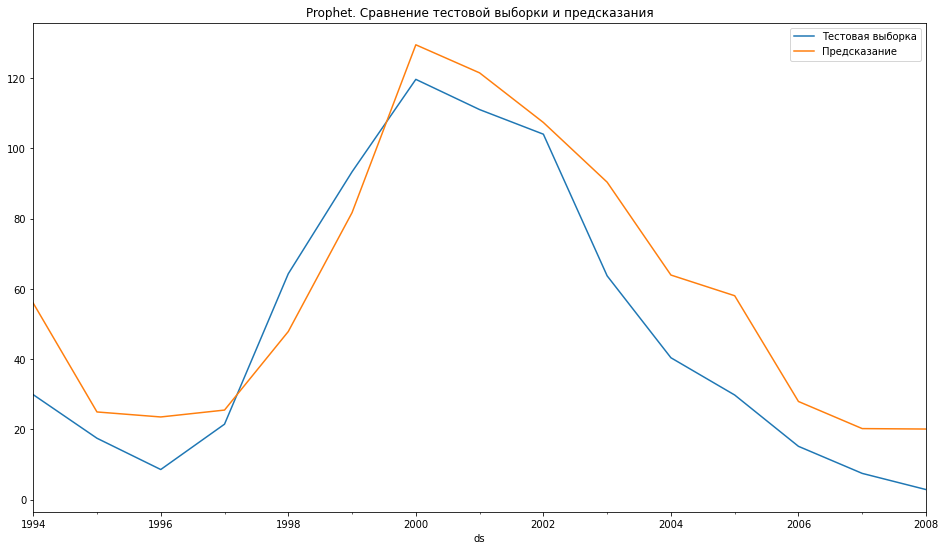

In [ ]:
ax1 = p_prediction['y'].plot(legend=True, title='Prophet. Сравнение тестовой выборки и предсказания')
ax2 = p_prediction['yhat'].plot(figsize=(16,9), legend=True) \
  .legend(['Тестовая выборка', 'Предсказание'])

Переобучим модель, учитывая специфику Prophet по работе с большими временными рядами.

In [ ]:
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

model = Prophet()
model.add_seasonality(
    name = 'century',
    fourier_order = 21,
    period = 103
)
model.fit(df_prophet[39:])
future = model.make_future_dataframe(periods=15, freq='YS')
forecast = model.predict(future)

In [ ]:
prediction = forecast.set_index('ds')[['yhat']]
prediction[-15:]

,yhat
ds,
2009-01-01,47.343924
2010-01-01,82.611948
2011-01-01,141.734170
2012-01-01,114.914247
2013-01-01,104.026790
2014-01-01,80.644903
2015-01-01,55.741624
2016-01-01,42.560719
2017-01-01,35.871275


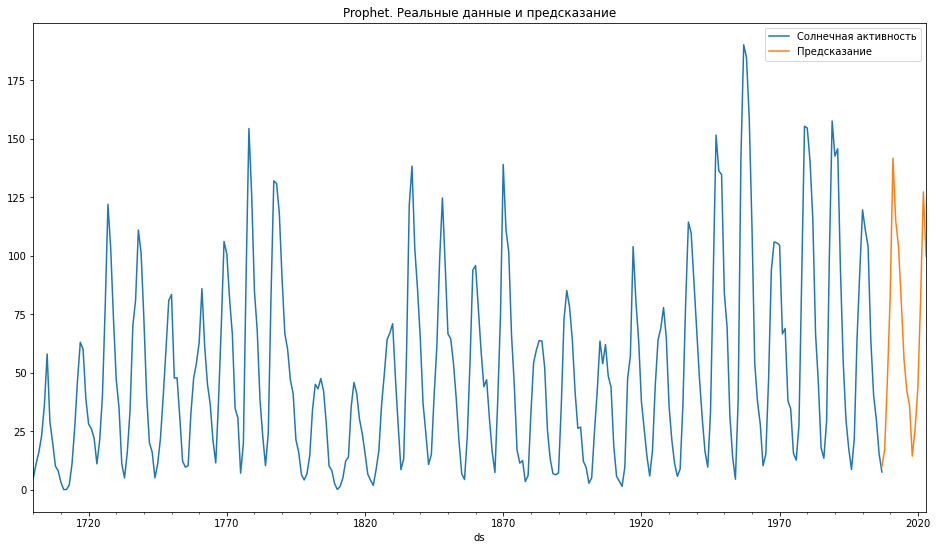

In [ ]:
ax1 = df_prophet[:-1].set_index('ds').plot(title='Prophet. Реальные данные и предсказание')
ax2 = prediction['yhat'][-17:].plot(figsize=(16,9)) \
  .legend(['Солнечная активность', 'Предсказание'])

Временные метки чуть сдвинуты, для лучшего восприятия графика.

## Выводы

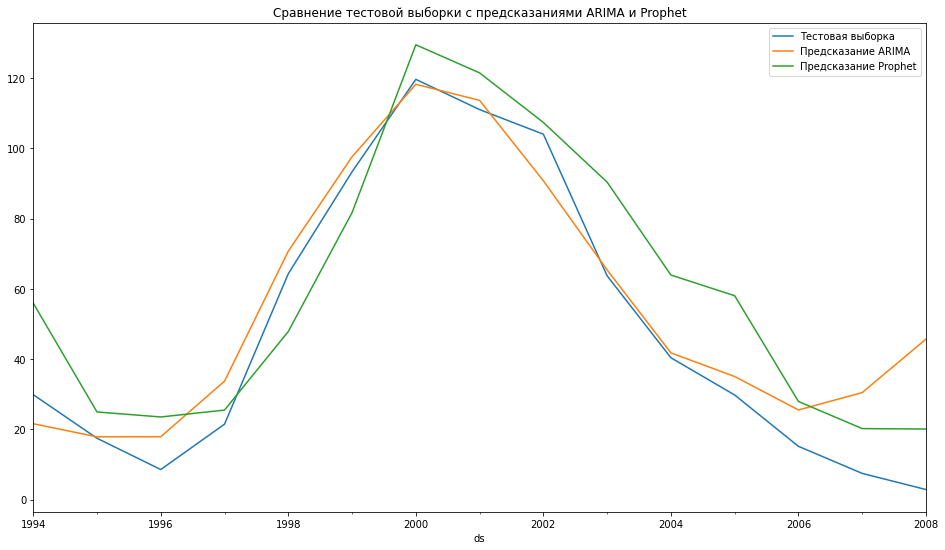

In [ ]:
ax1 = test.plot(title='Сравнение тестовой выборки с предсказаниями ARIMA и Prophet')
ax2 = st_prediction.plot(figsize=(16,9), legend=True)
ax3 = p_prediction['yhat'].plot(figsize=(16,9), legend=True) \
  .legend(['Тестовая выборка', 'Предсказание ARIMA', 'Предсказание Prophet'])

Было обучено две модели, ARIMA и Prophet. Произведена их проверка на тестовой выборке, с использованием визуальной оценки и метрик(MAPE, RMSE, MSE). Исходя из проведённого исследования стало ясно, что обе модели показали довольно низкий процент ошибки. Auto_arima делает использование модели ARIMA более простым, чем Prophet, также учитывая проблемы Prophet с большими временными рядами более 250 лет.